In [1]:
from getdist import loadMCSamples,plots,MCSamples
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d,CubicSpline
from scipy.optimize import minimize

import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 24
mpl.rcParams['axes.labelsize'] = 30


%matplotlib inline


# preview w0wa 

In [2]:
w0wa_root = './chains/desi_base_chains/'
cmb_desi1_panplus_w0wa = loadMCSamples(w0wa_root+'cmb_desi_panplus_w0wa/chain/2024-09-18_1000000_',settings={'ignore_rows':0.3})
cmb_desi1_panplus_w0wa.label='cmb_desi1_panplus_w0wa'

cmb_desi2_panplus_w0wa = loadMCSamples(w0wa_root+'PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000_',settings={'ignore_rows':0.3})
cmb_desi2_panplus_w0wa.label='cmb_desi2_panplus_w0wa'

cmb_desi2_desy5_w0wa = loadMCSamples(w0wa_root+'PlanckPR3_DESI2BAO_DESY5SN/chain/2025-04-21_5000000_',settings={'ignore_rows':0.3})
cmb_desi2_desy5_w0wa.label='cmb_desi2_desy5_w0wa'

./chains/desi_base_chains/cmb_desi_panplus_w0wa/chain/2024-09-18_1000000__1.txt
./chains/desi_base_chains/cmb_desi_panplus_w0wa/chain/2024-09-18_1000000__2.txt
Removed 0.3 as burn in
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__1.txt
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__10.txt
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__2.txt
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__3.txt
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__4.txt
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__5.txt
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__6.txt
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__7.txt
./chains/desi_base_chains/PlanckPR3_DESI2BAO_PanPlusSN/chain/2025-05-15_5000000__8.txt
./chains/desi_base_chains/PlanckP

In [3]:
print(cmb_desi1_panplus_w0wa.getGelmanRubin(),cmb_desi2_panplus_w0wa.getGelmanRubin(),cmb_desi2_desy5_w0wa.getGelmanRubin())

0.05659573946602541 0.008708169834469879 0.018576002315755468


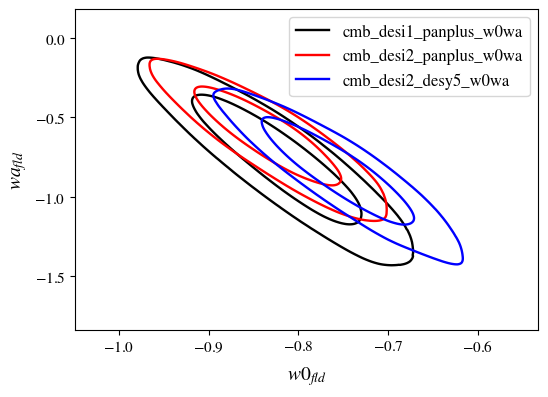

In [4]:
g = plots.get_single_plotter()
g.plot_2d([cmb_desi1_panplus_w0wa,
          cmb_desi2_panplus_w0wa,
          cmb_desi2_desy5_w0wa],'w0_fld','wa_fld')


g.add_legend(['cmb_desi1_panplus_w0wa',
              'cmb_desi2_panplus_w0wa',
             'cmb_desi2_desy5_w0wa'])

# Define the tramsform function

In [5]:
import emcee
from scipy.linalg import inv

def sample_w0wa_from_wzi(chain,z_at_transition,param_name):

    #param_name+=['winf_fld']
    #z_at_transition = np.append(z_at_transition,[10])
    
    data_z = z_at_transition
    data_a = 1 / (1 + data_z)  # Scale factor
    data_cov = chain.cov(param_name)
    data_mean = chain.mean(param_name)

    inv_cov = np.linalg.inv(data_cov)
    def loglkl(theta):
        w0,wa = theta
        w = w0 + wa * (1 - data_a)
        diff = w - data_mean
        return - 0.5 * diff @ inv_cov @ diff
    # MCMC setup
    ndim, nwalkers = 2, 10  # 2 parameters (w0, wa), 50 walkers
    initial_guess = [-1, 0]  # Example starting point
    pos = initial_guess + 0.5 * np.random.randn(nwalkers, ndim)  # Random initial positions

    # Initialize and run the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, loglkl)
    sampler.run_mcmc(pos, 20000, progress=True)

    # Get the samples
    emcee_samples = sampler.get_chain(discard=5000, thin=10, flat=True)
    
    emcee_samp = MCSamples(samples=emcee_samples,names=['w0_fld','wa_fld'],labels=[r'w_0',r'w_a'])
    return emcee_samp

# 9,13,16,19 bins: cmb_desi1_panplus 

In [6]:
rootpath='/data/luzhiyu/research/wbins_vs_w0wa/chains/'

In [7]:
z_at_transition_9 = np.array([0.,0.05,0.25,0.5,0.7,0.95,1.35,1.93,3.21]) 
param_name_9 = ['wbins__{}'.format(i) for i in range(1,9+1)]

z_at_transition_13 = np.array([0.,0.1,0.2,0.3,0.4,0.5,
                               0.7,0.9,1.1,1.6,2.0,2.5,3.5]) 
param_name_13 = ['wbins__{}'.format(i) for i in range(1,13+1)]

z_at_transition_16 = np.array([0.,0.1,0.2,0.3,0.4,0.5,
                               0.7,0.9,1.1,1.2,1.5,1.8,2.1,2.5,3.0,3.5]) 
param_name_16 = ['wbins__{}'.format(i) for i in range(1,16+1)]

z_at_transition_19 = np.array([0.,0.1,0.2,0.3,.4,.5,.6,.7,.8,.9,1.0,1.2,1.4,1.6,1.8,2.0,2.5,3.0,3.5]) 
param_name_19 = ['wbins__{}'.format(i) for i in range(1,19+1)]

In [8]:
cmb_desi1_panplus_bin9 = loadMCSamples(rootpath+'cmb_desi_panplus_interpbin9/chain/2025-05-15_5000000_',settings={'ignore_rows':0.5})
w0wa_bin9_cmb_desi1_panplus = sample_w0wa_from_wzi(cmb_desi1_panplus_bin9,z_at_transition_9,param_name_9)


cmb_desi1_panplus_bin13 = loadMCSamples(rootpath+'cmb_desi_panplus_interpbin13/chain/2025-05-15_5000000_',settings={'ignore_rows':0.5})
w0wa_bin13_cmb_desi1_panplus = sample_w0wa_from_wzi(cmb_desi1_panplus_bin13,z_at_transition_13,param_name_13)

cmb_desi1_panplus_bin16 = loadMCSamples(rootpath+'cmb_desi_panplus_interpbin16/chain/2025-05-15_5000000_',settings={'ignore_rows':0.5})
w0wa_bin16_cmb_desi1_panplus = sample_w0wa_from_wzi(cmb_desi1_panplus_bin16,z_at_transition_16,param_name_16)







100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1757.23it/s]


Removed no burn in


100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1724.18it/s]


Removed no burn in


100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1752.72it/s]

Removed no burn in


In [9]:
cmb_desi1_panplus_bin19 = loadMCSamples(rootpath+'cmb_desi_panplus_interpbin19/chain/2025-05-15_5000000_',settings={'ignore_rows':0.5})
w0wa_bin19_cmb_desi1_panplus = sample_w0wa_from_wzi(cmb_desi1_panplus_bin19,z_at_transition_19,param_name_19)


100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1749.67it/s]

Removed no burn in


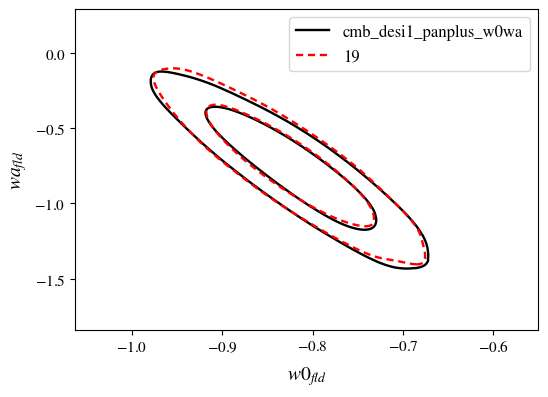

In [10]:
g = plots.get_single_plotter()
g.plot_2d([cmb_desi1_panplus_w0wa,
          w0wa_bin19_cmb_desi1_panplus],['w0_fld','wa_fld'],colors=['k','r'],
         ls=['-','--'])
g.add_legend(['cmb_desi1_panplus_w0wa','19'])




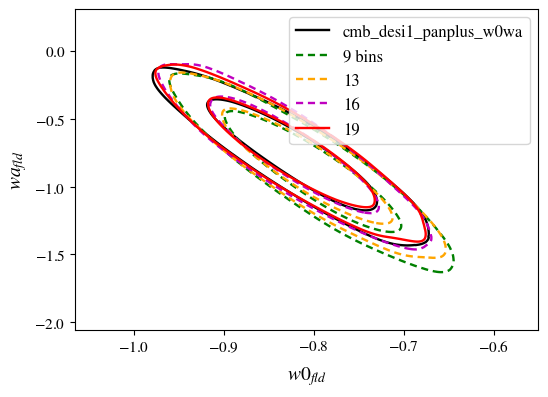

In [11]:
g = plots.get_single_plotter()
g.plot_2d([cmb_desi1_panplus_w0wa,
           w0wa_bin9_cmb_desi1_panplus,
          w0wa_bin13_cmb_desi1_panplus,
          w0wa_bin16_cmb_desi1_panplus,
          w0wa_bin19_cmb_desi1_panplus],['w0_fld','wa_fld'],colors=['k','g','orange','m','r'],
         ls=['-','--','--','--','-'])
g.add_legend(['cmb_desi1_panplus_w0wa','9 bins','13','16','19'])




# 19 bins: cmb_desi2_panplus

In [12]:

cmb_desi2_panplus_bin19 = loadMCSamples(rootpath+'cmb_desi2_panplus_interpbin19/chain/2025-05-15_5000000_',settings={'ignore_rows':0.3})
w0wa_bin19_cmb_desi2_panplus = sample_w0wa_from_wzi(cmb_desi2_panplus_bin19,z_at_transition_19,param_name_19)


100%|███████████████████████████████████| 20000/20000 [00:11<00:00, 1714.97it/s]

Removed no burn in


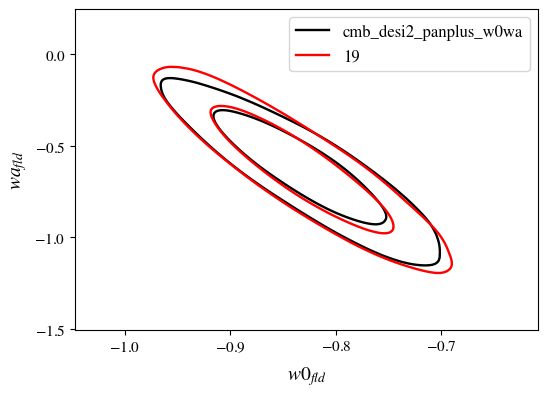

In [13]:
g = plots.get_single_plotter()
g.plot_2d([cmb_desi2_panplus_w0wa,
          w0wa_bin19_cmb_desi2_panplus],['w0_fld','wa_fld'],colors=['k','r'],
         )
g.add_legend(['cmb_desi2_panplus_w0wa','19'])




# 19bins: cmb_desi2_desy5

In [14]:

cmb_desi2_desy5_bin19 = loadMCSamples(rootpath+'cmb_desi2_desy5_interpbin19/chain/2025-05-16_5000000_',settings={'ignore_rows':0.5})
w0wa_bin19_cmb_desi2_desy5 = sample_w0wa_from_wzi(cmb_desi2_desy5_bin19,z_at_transition_19,param_name_19)


100%|███████████████████████████████████| 20000/20000 [00:12<00:00, 1552.06it/s]

Removed no burn in


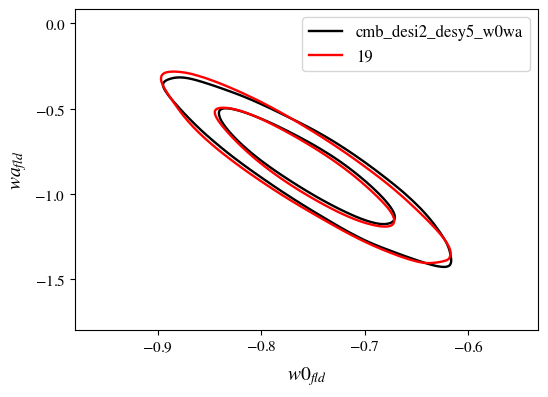

In [15]:
g = plots.get_single_plotter()
g.plot_2d([cmb_desi2_desy5_w0wa,
          w0wa_bin19_cmb_desi2_desy5],['w0_fld','wa_fld'],colors=['k','r'],
         )
g.add_legend(['cmb_desi2_desy5_w0wa','19'])




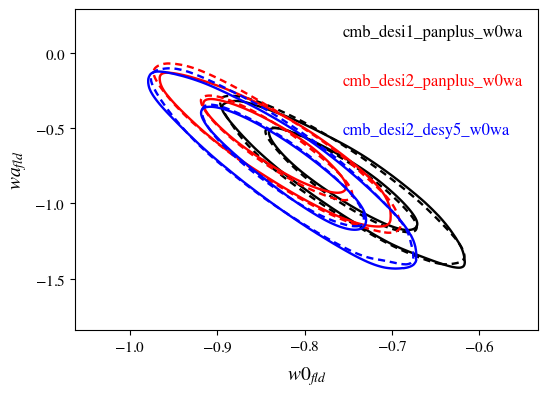

In [16]:
g = plots.get_single_plotter()
g.plot_2d([cmb_desi2_desy5_w0wa,
          w0wa_bin19_cmb_desi2_desy5,
           cmb_desi2_panplus_w0wa,
          w0wa_bin19_cmb_desi2_panplus,
          cmb_desi1_panplus_w0wa,
          w0wa_bin19_cmb_desi1_panplus],['w0_fld','wa_fld'],
          colors=['k','k','r','r','b','b'],
          ls=['-','--','-','--','-','--']
         )
#g.add_legend(['MCMC w0wa','19'])

g.add_legend(['cmb_desi1_panplus_w0wa','',
              'cmb_desi2_panplus_w0wa','',
             'cmb_desi2_desy5_w0wa',''],colored_text=True)




# save data as dict

In [17]:
# import h5py
# import numpy as np


# with h5py.File('w0wa_wbins_data.h5', 'w') as f:
#     f.attrs['info'] = 'This is cov and mean for different models and dataset, here cmb=PlanckPR3, desi1=DESIDR1BAO, desi2=DESIDR2BAO, panplus/desy5 are the SN data'
    
#     group_names=['cmb_desi1_panplus_w0wa','cmb_desi2_panplus_w0wa','cmb_desi2_desy5_w0wa']
#     for name in group_names:
#         obj = globals()[name]
#         group = f.create_group(name)
#         param_name = ['w0_fld','wa_fld','Omega_m']
#         group.create_dataset('cov', data=obj.cov(param_name))
#         group.create_dataset('mean', data=obj.mean(param_name))
    
#         dt = h5py.string_dtype(encoding='utf-8')
#         group.create_dataset('param_name', data=param_name, dtype=dt)
        
    
#     group_names=['cmb_desi1_panplus_bin9','cmb_desi1_panplus_bin13','cmb_desi1_panplus_bin16','cmb_desi1_panplus_bin19',
#                 'cmb_desi2_panplus_bin19','cmb_desi2_desy5_bin19']
#     param_name = [param_name_9+['winf_fld','Omega_m'],
#                   param_name_13+['winf_fld','Omega_m'],
#                   param_name_16+['winf_fld','Omega_m'],
#                   param_name_19+['winf_fld','Omega_m'],
#                   param_name_19+['winf_fld','Omega_m'],
#                   param_name_19+['winf_fld','Omega_m']]
#     z_point=[z_at_transition_9,z_at_transition_13,z_at_transition_16,z_at_transition_19,
#             z_at_transition_19,z_at_transition_19]
#     for i,name in enumerate(group_names):
#         obj = globals()[name]
#         group = f.create_group(name)
#         group.create_dataset('cov', data=obj.cov(param_name[i]))
#         group.create_dataset('mean', data=obj.mean(param_name[i]))
    
#         dt = h5py.string_dtype(encoding='utf-8')
#         group.create_dataset('param_name', data=param_name[i], dtype=dt)
#         group.create_dataset('z_knot', data=z_point[i])

In [18]:
# def get_dict_from_hdf5(group, none_flag="NoneValue"):
#     d = {}
#     for key in group.keys():
#         if isinstance(group[key], h5py.Group):
#             d[key] = get_dict_from_hdf5(group[key], none_flag=none_flag)
#         elif isinstance(group[key], h5py.Dataset):
#             data = group[key][()]

#             if np.array_equal(data, none_flag):
#                 d[key] = None
#             else:
#                 d[key] = data
#     return d

# with h5py.File('w0wa_wbins_data.h5', 'r') as hf: 
#     L = get_dict_from_hdf5(hf)

In [20]:
# def print_dict_keys(d, indent=0):
#     for key, value in d.items():
#         print('  ' * indent + str(key))
#         if isinstance(value, dict):
#             print_dict_keys(value, indent + 1)
# print_dict_keys(L)